In [19]:
import os
import sys

import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

In [2]:
def ingest_and_process(
    output_grid: np.ndarray,
    var: str = "tos", 
    cmipTable: str ="Omon", 
    era: str = "CMIP6",
    testing: bool = False,
    calc_anoms: bool = False
) -> dict:
    """
    Ingests all the data from the CMIP piControl experiment. 
    Optionally remove the seasonal cycle and detrend the data, regrid to a commond 2.5 x 2.5 degree grid and return a new dataset

    Returns:
        xarray datasets with dimensions (model, time, lat, lon)
    """

    # Specify the ensemble member
    if era == "CMIP6": 
        member = "r1i1p1f1"
    else:
        member = "r1i1p1"

    # Find all the paths to the data
    dpaths = xs.findPaths(
        experiment="piControl",
        variable=var,
        frequency="mon",
        cmipTable=cmipTable,
        mip_era=era, 
        activity="CMIP",
        member=member
    )
    models =  xs.getGroupValues(dpaths, 'model')
    dpaths = list(dpaths.keys())
    
    # Create an empty Dataset
    ds = []
    valid_models = []

    for i, (model_path, model) in enumerate(zip(dpaths, models)):
        print("Starting model: ", model)
        print("Model path: ", model_path)

        try:
            # Load data
            da = xc.open_mfdataset(glob(model_path + "/*.nc")) #, parallel=True, chunks="auto")

            # Regrid Data
            output = da.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

            # Deseasonalize (no need to detrend piControl data, there should be no drift)
            if calc_anoms:
                output = output.temporal.departures(var, "month")

            ntime, _, _ = output[var].shape

            nmonths = 150*12
            if ntime < nmonths:
                continue

            output = output[var][:nmonths]
            time = np.arange(np.datetime64("1850-01"), np.datetime64("1850-01") + np.timedelta64(nmonths, 'M'), dtype="datetime64[M]")
            output["time"] = time
            ds.append(output)
            valid_models.append(model)

            # Only load one model if testing
            if testing:
                _, axes = plt.subplots(ncols=2, figsize=(16, 4))
                da[var].isel(time=0).plot(ax=axes[0])
                axes[0].set_title('Input data')
                output.isel(time=0).plot(ax=axes[1])
                axes[1].set_title('Output data')
                plt.tight_layout()

                if i == 1:
                    break
        
        except Exception as e:
            print("Model failed: ", model, e)

    ds = xr.concat(ds, dim='model')
    ds.coords['model'] = list(valid_models)

    return ds


def collect_data():
    """
    Iterate through all the variables and eras and save the data
    """

    # Define Constants
    eras = ["CMIP6"] #, "CMIP5"]
    variables = ["rsutcs", "rsut", "tos"] # tos == sea surface temperature
    calc_anoms = False

    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    for era in eras: 
        print("Starting era: ", era)
        for var in variables:
            print("Starting variable: ", var)

            if var == "tos": 
                table = "Omon"
            else: 
                table = "Amon"

            ds = ingest_and_process(
                var=var,
                cmipTable=table,
                era=era,
                testing=TESTING,
                output_grid=output_grid,
                calc_anoms=False
            )

            print(ds)
            if calc_anoms:
                ds.to_netcdf(f"data/{var}_mon_1850-2100_anoms_{era}_piControl.nc")
                ds.close()
            else: 
                ds.to_netcdf(f"data/{var}_mon_1850-2100_{era}_piControl.nc")
                ds.close()
                

        break


TESTING = False
collect_data()

Starting era:  CMIP6
Starting variable:  rsutcs
Starting model:  E3SM-1-1
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Amon/rsutcs/gr/v20201123/
Starting model:  E3SM-1-0
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Amon/rsutcs/gr/v20190719/
Starting model:  E3SM-1-1-ECA
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/piControl/r1i1p1f1/Amon/rsutcs/gr/v20201204/
Starting model:  KIOST-ESM
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/KIOST/KIOST-ESM/piControl/r1i1p1f1/Amon/rsutcs/gr1/v20210810/
Starting model:  CIESM
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/THU/CIESM/piControl/r1i1p1f1/Amon/rsutcs/gr/v20200806/
Starting model:  BCC-ESM1
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/BCC/BCC-ESM1/piControl/r1i1p1f1/Amon/rsutcs/gn/v20181214/
Starting model:  BCC-CSM2-MR
Model path:  /p/css03/esgf_publish/CMIP6/CMIP/BCC/BCC-CSM2-MR/piControl/r1i1p1f1/Amon/rsutcs/gn/v20181016/
St

KeyboardInterrupt: 

In [40]:
dpaths_tos = xs.findPaths(
        experiment="piControl",
        variable="tos",
        frequency="mon",
        cmipTable="Omon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_tos.keys()))
models_tos =  xs.getGroupValues(dpaths_tos, 'model')
print(len(models_tos))

dpaths_rsus = xs.findPaths(
        experiment="piControl",
        variable="rsus",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_rsus.keys()))
models_rsus =  xs.getGroupValues(dpaths_rsus, 'model')
print(len(models_rsus))

dpaths_rsuscs = xs.findPaths(
        experiment="piControl",
        variable="rsuscs",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP6", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1f1"
)
print(len(dpaths_rsuscs.keys()))
models_rsuscs =  xs.getGroupValues(dpaths_rsuscs, 'model')
print(len(models_rsuscs))

shared_models = list(set.intersection(set(models_tos), set(models_rsus), set(models_rsuscs)))
shared_paths = list(set.intersection(set(dpaths_tos), set(dpaths_rsus), set(dpaths_rsuscs)))
print(len(shared_paths),len(shared_models))
# print(shared_models)
print(dpaths_tos)
print(dpaths_rsus)
print(shared_models)

57
57
58
58
57
57
0 55
{'/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v20201125/': {'keyid': 'CMIP6.CMIP.E3SM-Project.E3SM-1-1.piControl.r1i1p1f1.Omon.ocean.mon.tos.gr.glb-2d-gr.v20201125', 'mip_era': 'CMIP6', 'activity': 'CMIP', 'institute': 'E3SM-Project', 'model': 'E3SM-1-1', 'experiment': 'piControl', 'member': 'r1i1p1f1', 'cmipTable': 'Omon', 'realm': 'ocean', 'frequency': 'mon', 'variable': 'tos', 'grid': 'gr', 'gridLabel': 'glb-2d-gr', 'version': 'v20201125', 'timepoints': 3012, 'nfiles': 51, 'nc_creation_date': '20191028', 'sumfilesize_bytes': 463466872, 'has_zero_size_files': 0, 'created': '2021-09-30 09:58:19', 'modified': '2020-11-30 17:01:27', 'accessed': '2022-10-04 14:34:56', 'retired': 0, 'retire_datetime': None, 'retracted': 0, 'retracted_datetime': None, 'ignored': 0, 'ignored_datetime': None, 'comment': None, 'unique': True, 'alternate_paths': ['/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v201910

In [39]:
dpaths_tos = xs.findPaths(
        experiment="piControl",
        variable="tos",
        frequency="mon",
        cmipTable="Omon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_tos.keys()))
# print(dpaths_tos)
models_tos =  xs.getGroupValues(dpaths_tos, 'model')
print(len(models_tos))

dpaths_rsus = xs.findPaths(
        experiment="piControl",
        variable="rsus",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_rsus.keys()))
models_rsus =  xs.getGroupValues(dpaths_rsus, 'model')
print(len(models_rsus))

dpaths_rsuscs = xs.findPaths(
        experiment="piControl",
        variable="rsuscs",
        frequency="mon",
        cmipTable="Amon",
        mip_era="CMIP5", 
        # model="CanESM5-1",
        activity="CMIP",
        member="r1i1p1"
)
print(len(dpaths_rsuscs.keys()))
models_rsuscs =  xs.getGroupValues(dpaths_rsuscs, 'model')
print(len(models_rsuscs))

shared_models = list(set.intersection(set(models_tos), set(models_rsus), set(models_rsuscs)))
shared_paths = list(set.intersection(set(dpaths_tos), set(dpaths_rsus), set(dpaths_rsuscs)))
print(len(shared_paths),len(shared_models))
print(shared_models)

41
41
44
44
40
40
0 36
['NorESM1-M', 'GFDL-ESM2M', 'GISS-E2-H', 'MRI-CGCM3', 'IPSL-CM5A-LR', 'CNRM-CM5-2', 'bcc-csm1-1-m', 'CanESM2', 'MPI-ESM-LR', 'MIROC5', 'CESM1-FASTCHEM', 'NorESM1-ME', 'GISS-E2-R-CC', 'HadGEM2-CC', 'CCSM4', 'GFDL-CM3', 'CESM1-BGC', 'GISS-E2-H-CC', 'FIO-ESM', 'HadGEM2-ES', 'CSIRO-Mk3-6-0', 'inmcm4', 'bcc-csm1-1', 'BNU-ESM', 'IPSL-CM5A-MR', 'IPSL-CM5B-LR', 'MIROC-ESM', 'CESM1-CAM5', 'MPI-ESM-P', 'ACCESS1-0', 'MIROC-ESM-CHEM', 'GFDL-ESM2G', 'ACCESS1-3', 'CNRM-CM5', 'MPI-ESM-MR', 'CESM1-WACCM']


In [11]:
def ingest_and_process(
    output_grid: np.ndarray,
    var: str = "tos", 
    cmipTable: str ="Omon", 
    era: str = "CMIP6",
    testing: bool = False,
    calc_anoms: bool = False
) -> dict:
    """
    Ingests all the data from the CMIP piControl experiment. 
    Optionally remove the seasonal cycle and detrend the data, regrid to a commond 2.5 x 2.5 degree grid and return a new dataset

    Returns:
        xarray datasets with dimensions (model, time, lat, lon)
    """
    
    # Find all the paths to the data
    dpaths = xs.findPaths(
        experiment="piControl",
        variable=var,
        frequency="mon",
        cmipTable=cmipTable,
        mip_era=era, 
        activity="CMIP",
    )
    models =  xs.getGroupValues(dpaths, 'model')
    dpaths = list(dpaths.keys())
    
    # Create an empty Dataset
    ds = []
    valid_models = []

    for i, (model_path, model) in enumerate(zip(dpaths, models)):
        if model != "CanESM5-1": continue
        import pdb; pdb.set_trace()
        try:
            print("Starting model: ", model)
            # Load data
            print(model_path)
            da = xc.open_mfdataset(glob(model_path + "/*.nc")) #, parallel=True, chunks="auto")

            # Regrid Data
            output = da.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

            # Deseasonalize (no need to detrend piControl data, there should be no drift)
            if calc_anoms:
                output = output.temporal.departures(var, "month")

            ntime, _, _ = output[var].shape

            nmonths = 150*12
            if ntime < nmonths:
                continue

            output = output[var][:nmonths]
            time = np.arange(np.datetime64("1850-01"), np.datetime64("1850-01") + np.timedelta64(nmonths, 'M'), dtype="datetime64[M]")
            output["time"] = time
            ds.append(output)
            valid_models.append(model)

            # Only load one model if testing
            if testing:
                _, axes = plt.subplots(ncols=2, figsize=(16, 4))
                da[var].isel(time=0).plot(ax=axes[0])
                axes[0].set_title('Input data')
                output.isel(time=0).plot(ax=axes[1])
                axes[1].set_title('Output data')
                plt.tight_layout()

                if i == 1:
                    break
        
        except Exception as e:
            print("Model failed: ", model, e)
            continue

    ds = xr.concat(ds, dim='model')
    ds.coords['model'] = list(valid_models)

    return ds


def collect_data():
    """
    Iterate through all the variables and eras and save the data
    """

    # Define Constants
    eras = ["CMIP6"] #, "CMIP5"]
    variables = ["tos", "rsutcs", "rsut"] # tos == sea surface temperature
    calc_anoms = False

    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    for era in eras: 
        print("Starting era: ", era)
        for var in variables:
            print("Starting variable: ", var)

            if var == "tos": 
                table = "Omon"
            else: 
                table = "Amon"

            ds = ingest_and_process(
                var=var,
                cmipTable=table,
                era=era,
                testing=False,
                output_grid=output_grid,
                calc_anoms=False
            )

            print(ds)

        break

collect_data()

Starting era:  CMIP6
Starting variable:  tos
> /tmp/ipykernel_35612/3542508154.py(36)ingest_and_process()
     34         if model != "CanESM5-1": continue
     35         import pdb; pdb.set_trace()
---> 36         try:
     37             print("Starting model: ", model)
     38             # Load data

CanESM5-1
CanESM5-1
/p/css03/esgf_publish/CMIP6/CMIP/MIROC/MIROC-ES2H/piControl/r1i1p4f2/Omon/tos/gn/v20220322/
['/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1/piControl/r1i1p1f1/Omon/tos/gr/v20201125/', '/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-0/piControl/r1i1p1f1/Omon/tos/gr/v20200129/', '/p/user_pub/work/CMIP6/CMIP/E3SM-Project/E3SM-1-1-ECA/piControl/r1i1p1f1/Omon/tos/gr/v20201203/', '/p/css03/esgf_publish/CMIP6/CMIP/KIOST/KIOST-ESM/piControl/r1i1p1f1/Omon/tos/gr1/v20220204/', '/p/css03/scratch/cmip6/CMIP/THU/CIESM/piControl/r1i1p1f1/Omon/tos/gn/v20200220/', '/p/css03/esgf_publish/CMIP6/CMIP/CNRM-CERFACS/CNRM-CM6-1-HR/piControl/r1i1p1f2/Omon/tos/gn/v20191021/', '/p/css0

<xarray.DataArray 'lat' (lat: 4)>
array([-3.75, -1.25,  1.25,  3.75])
Coordinates:
  * lat      (lat) float64 -3.75 -1.25 1.25 3.75
    model    <U10 'bcc-csm1-1'


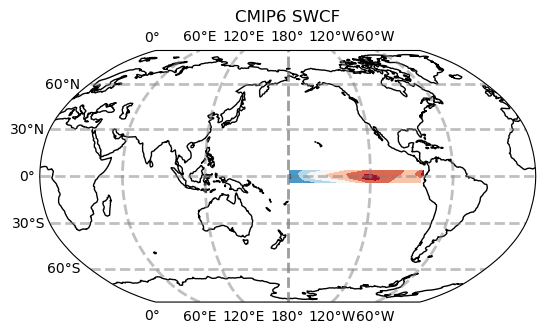

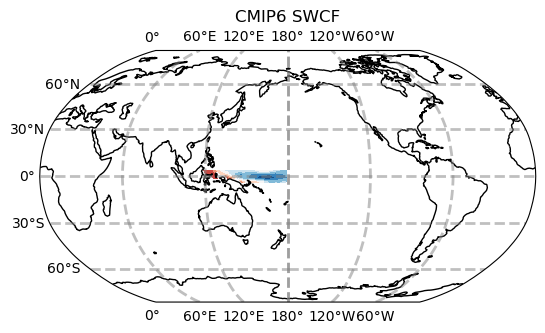

In [10]:
def global_plot(data, lon, lat, cmap, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
    ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    plt.show()

    
swcf_cmip6 = xr.open_dataarray(f"data/swcf_cmip5_monthly_1850-2000.nc", chunks="auto").to_dataset(name="swcf")
swcf_cmip6 = xc.swap_lon_axis(swcf_cmip6, to=(-180, 180))
swcf_east = swcf_cmip6.sel(lon=slice(-180, -80), lat=slice(-5, 5)).isel(model=14)
swcf_west = swcf_cmip6.sel(lon=slice(110, 180), lat=slice(-5, 5)).isel(model=14)
print(swcf_west.lat)

global_plot(lon=swcf_east.lon, lat=swcf_east.lat, data=swcf_east.swcf, cmap="RdBu_r", title="CMIP6 SWCF")
global_plot(lon=swcf_west.lon, lat=swcf_west.lat, data=swcf_west.swcf, cmap="RdBu_r", title="CMIP6 SWCF")
# swcf_cmip6.isel(model=1)

In [15]:
swcf_cmip6.close()

In [4]:
swcre_cmip6 = xr.open_dataset(f"data/swcre_cmip6_monthly_1850-2000.nc", chunks="auto") #.to_dataset(name="swcf")
swcre_cmip6 = xc.swap_lon_axis(swcre_cmip6, to=(-180, 180))
print(swcre_cmip6.lat)
# West pacific
swcre_west = swcre_cmip6.sel(lon=slice(130, 180), lat=slice(-7, 7)).isel(time=1,model=1)
# East pacific
swcre_east = swcre_cmip6.sel(lon=slice(-130, -80), lat=slice(-7, 7)).isel(time=1,model=1)

global_plot(lon=swcre_west.lon, lat=swcre_west.lat, data=swcre_west.swcre, cmap="RdBu_r", title="CMIP6 SWCF")
global_plot(lon=swcre_east.lon, lat=swcre_east.lat, data=swcre_east.swcre, cmap="RdBu_r", title="CMIP6 SWCF")

<xarray.DataArray 'lat' (lat: 72)>
array([-88.75, -86.25, -83.75, -81.25, -78.75, -76.25, -73.75, -71.25, -68.75,
       -66.25, -63.75, -61.25, -58.75, -56.25, -53.75, -51.25, -48.75, -46.25,
       -43.75, -41.25, -38.75, -36.25, -33.75, -31.25, -28.75, -26.25, -23.75,
       -21.25, -18.75, -16.25, -13.75, -11.25,  -8.75,  -6.25,  -3.75,  -1.25,
         1.25,   3.75,   6.25,   8.75,  11.25,  13.75,  16.25,  18.75,  21.25,
        23.75,  26.25,  28.75,  31.25,  33.75,  36.25,  38.75,  41.25,  43.75,
        46.25,  48.75,  51.25,  53.75,  56.25,  58.75,  61.25,  63.75,  66.25,
        68.75,  71.25,  73.75,  76.25,  78.75,  81.25,  83.75,  86.25,  88.75])
Coordinates:
  * lat      (lat) float64 -88.75 -86.25 -83.75 -81.25 ... 83.75 86.25 88.75
Attributes:
    units:    degrees_north
    axis:     Y
    bounds:   lat_bnds


NameError: name 'global_plot' is not defined

In [15]:
swcre_anoms = xr.open_dataset(f"data/swcre_cmip6_anoms_monthly_1850-2000.nc", chunks="auto").mean("model")["swcre_anoms"]
tos_anoms = xr.open_dataset(f"data/tos_anoms_mon_1850-2100_CMIP6_piControl.nc", chunks="auto").mean("model")["tos"]
tos_anoms = tos_anoms.chunk({"time": -1})
swcre_anoms = swcre_anoms.chunk({"time": -1})

In [37]:
r = xscore.pearson_r(swcre_anoms, tos_anoms, dim="time")
p = xscore.pearson_r_p_value(swcre_anoms, tos_anoms, dim="time")

def fix_coords(data, var):
    data = data.rename(var).to_dataset().bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    data = data[var]
    return data

r = fix_coords(r, "r")
p = fix_coords(p, "p")


2023-06-22 09:10:15,956 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


2023-06-22 09:10:15,991 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


In [2]:
def global_plot_stippling(data, lon, lat, p, cmap, title=""):
    # plot map of global data with central longitude 180
    fig = plt.figure()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=180))
    img = ax1.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        levels=np.arange(-.8, .9, 0.1),
    )
    gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    
    ax1.contourf(
        lon, lat, p,
        transform=ccrs.PlateCarree(), colors='none', levels=[0, 0.05, 1],
        hatches=["...", ""]
    )
    ax1.coastlines()
    ax1.set_global()
    ax1.set_title(title)
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    plt.show()

In [57]:
global_plot_stippling(lon=swcre_cmip6.lon, lat=swcre_cmip6.lat, data=r, p=p, cmap="RdBu_r", title="CMIP6 r(SWCRE, SST)")

# Start development for Percentile based SST analysis
TODO:
1. dfsdfa
2. think about weighting
3. what region should I do (5S - 5N or 30S - 30N)
4. Why sstsharp - sstflat is negative?
5. DONE: sanity check more stuff
6. finish pipeline for swcre and swcf
7. figure out why positive 30 year trends for W-E pacific
8. DONE: expand figures to sanity check 30 year trends and plot distribution

In [3]:
"""
Library to compute weighted quantiles, including the weighted median, of
numpy arrays.

https://github.com/nudomarinero/wquantiles
"""
def quantile_1D(data, weights, quantile):
    """
    Compute the weighted quantile of a 1D numpy array.

    Parameters
    ----------
    data : ndarray
        Input array (one dimension).
    weights : ndarray
        Array with the weights of the same size of `data`.
    quantile : float
        Quantile to compute. It must have a value between 0 and 1.

    Returns
    -------
    quantile_1D : float
        The output value.
    """
    # Check the data
    if not isinstance(data, np.matrix):
        data = np.asarray(data)
    if not isinstance(weights, np.matrix):
        weights = np.asarray(weights)
    nd = data.ndim
    if nd != 1:
        raise TypeError("data must be a one dimensional array")
    ndw = weights.ndim
    if ndw != 1:
        raise TypeError("weights must be a one dimensional array")
    if data.shape != weights.shape:
        raise TypeError("the length of data and weights must be the same")
    if ((quantile > 1.) or (quantile < 0.)):
        raise ValueError("quantile must have a value between 0. and 1.")
    # Sort the data
    ind_sorted = np.argsort(data)
    sorted_data = data[ind_sorted]
    sorted_weights = weights[ind_sorted]
    # Compute the auxiliary arrays
    Sn = np.cumsum(sorted_weights)
    # TODO: Check that the weights do not sum zero
    #assert Sn != 0, "The sum of the weights must not be zero"
    Pn = (Sn-0.5*sorted_weights)/Sn[-1]
    # Get the value of the weighted median
    return np.interp(quantile, Pn, sorted_data)


def get_percentiles(data,wts,bins):
    # wrapper for previous functions
    quantiles = bins/100
    newbins=[]
    for q in quantiles:
        newbins.append(np.quantile(data, q))
        # newbins.append(quantile_1D(data, wts, q))
    return newbins

# bins = get_percentiles(np.random.rand((100)), np.ones(100)/100, bins=np.arange(0, 110, 10))
# bins

In [7]:
def do_SSTsharp_sorting(ds: xr.DataArray, prctl_bins: np.ndarray, prctl_binmids: np.ndarray) -> xr.Dataset:
    """The goal of this function is to calculate SSTsharp as defined in Fueglistaler (2019)

        Observational evidence for two modes of coupling between sea surface temperatures, 
        tropospheric temperature profile, and shortwave cloud radiative effect in the tropics. 
        Geophysical Research Letters, 46, 9890–9898. https://doi.org/10.1029/2019GL083990

    Args:
        ds (xr.DataArray): _description_
        nbins (int, optional): _description_. Defaults to 20.

    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average temperature in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average temperature in each percentile bin minus the monthly climatology
            sortIdxs (xr.DataArray)[time, lon]: Indexes of the sorted data that can be used to sort other dataX (e.g. swcre, rsut, rsutcs) using dataY (e.g. SST)
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SST at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 

    """
    ntime, nlon = ds.shape
    nbins = len(prctl_bins)

    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))
    sortIdxs = np.zeros((ntime,nlon))

    for i in range(ntime):
        if i % 100 == 0:
            print("starting time step: ", i, " of ", ntime)
        ds_slice = ds.isel(time=i)
        # Remove nans
        pass
        # Get weights (if we stick to the ocean, we don't need this)
        wts = np.ones(len(ds_slice))

        # Calculate percentiles (these are the values separating the quantiles)
        bins = get_percentiles(ds_slice, wts, prctl_bins)
        inds = np.digitize(ds_slice, bins)
        sortIdxs[i,:] = inds

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(ds_slice[np.where(inds==b)]*wts[np.where(inds==b)])
            denom = np.nansum(wts[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    for m in range(12):
        binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    
    # Time slice SST mean
    TMean = np.nanmean(binanom, axis=1)[:, None]
    # Calculate binanom_bar
    binanom_bar = binanom - TMean
    # Calculate SSTsharp 
    sharpThreshold = np.where(prctl_bins==30)[0][0]+1    
    sharp = np.nansum(binanom_bar[:,:sharpThreshold]*binwts[:,:sharpThreshold],1) / np.nansum(binwts[:,:sharpThreshold],1)
    # Calculate SSTflat
    flatThreshold = np.where(prctl_bins==75)[0][0]    
    flat = np.nansum(binanom_bar[:,flatThreshold:]*binwts[:,flatThreshold:],1) / np.nansum(binwts[:,flatThreshold:],1)

    TMean = TMean.squeeze()

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'sortIdxs': (('time','lon'), sortIdxs), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': ds.time, 
            'bins': prctl_binmids.data,
            'lon': ds.lon 
        }
    ) 
    
    return ds


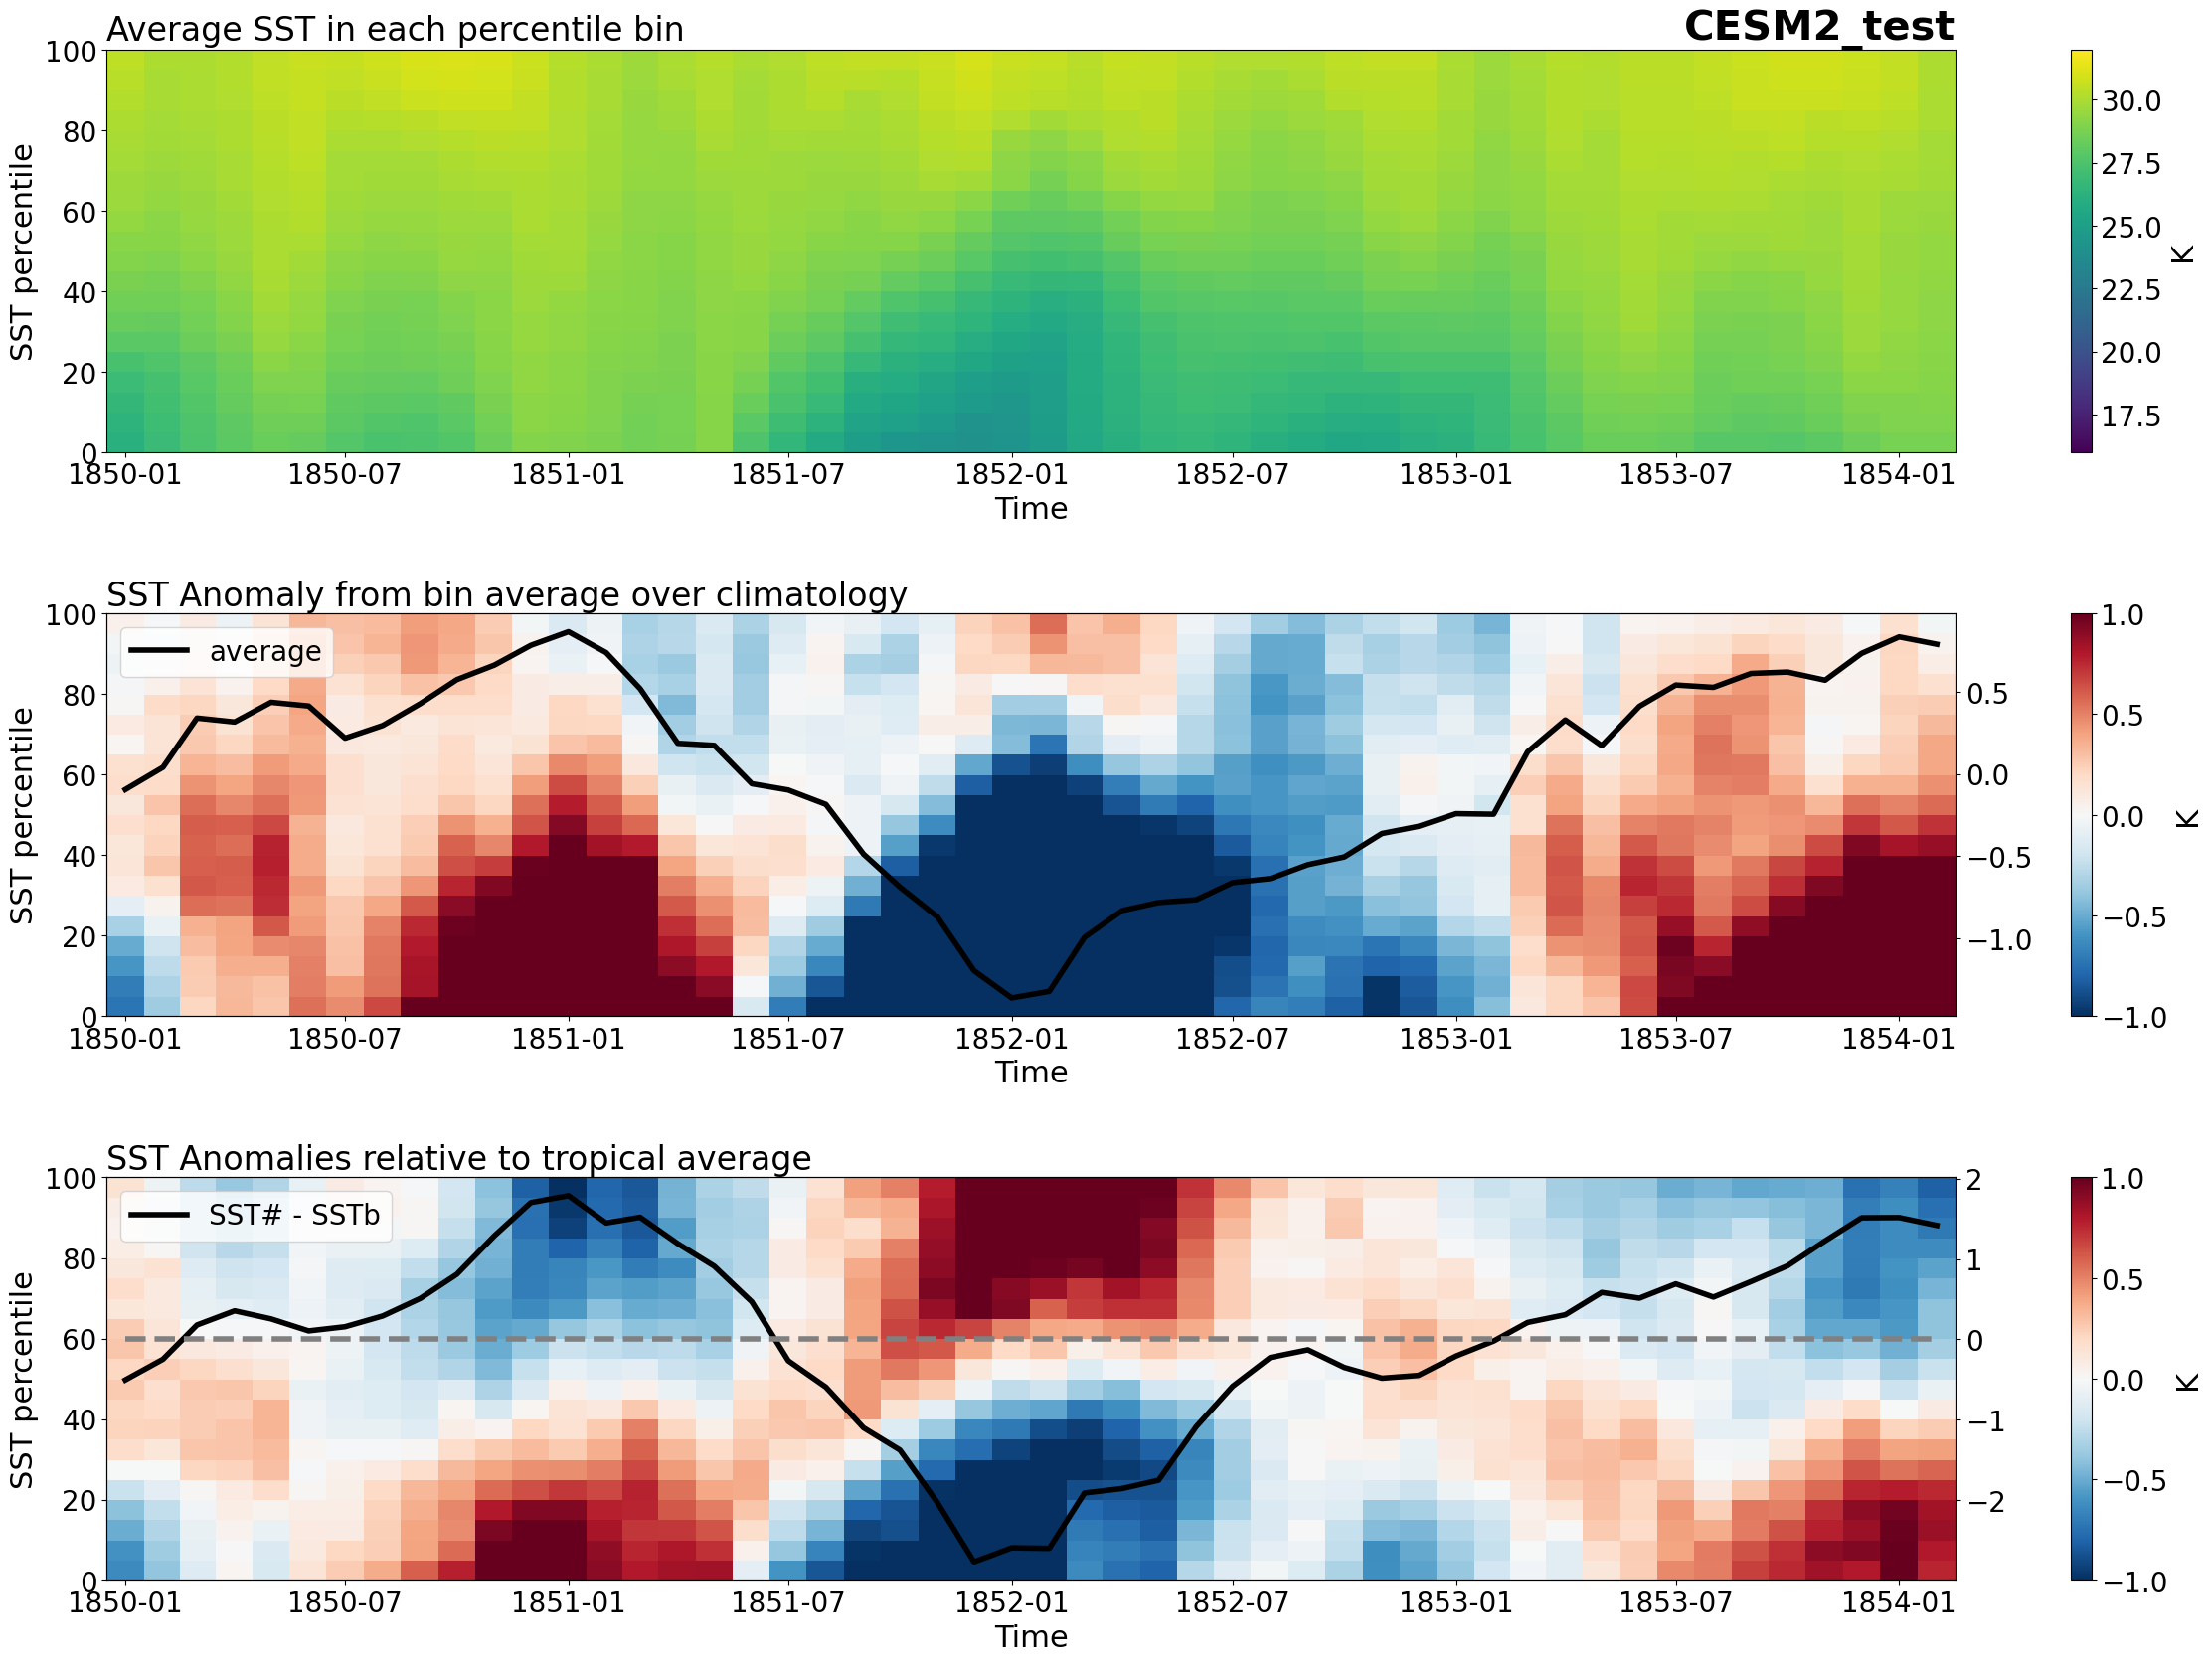

In [50]:
plt.rcParams.update({
    'font.size': 22,        # Global font size
    'axes.labelsize': 22,   # Font size for axis labels
    'axes.titlesize': 24,   # Font size for subplot titles
    'legend.fontsize': 20,  # Font size for legend
    'xtick.labelsize': 20,  # Font size for x-axis tick labels
    'ytick.labelsize': 20   # Font size for y-axis tick labels
})

def create_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T, vmin=16,vmax=32) 
    axes[0].set_title("Average SST in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('K')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, vmin=-1,vmax=1, cmap='RdBu_r')
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SST Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label('K')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, vmin=-1,vmax=1, cmap='RdBu_r')
    axes[2].set_title("SST Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SST# - SSTb", linewidth=4)
    twin_ax2.hlines(np.nanmean(-(ds.sharp - ds.flat)), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label('K')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_percentiles.png", bbox_inches='tight')

create_percentile_figures(ds, model="CESM2_test")

In [ ]:
def create_swcre_percentile_figures(ds: xr.Dataset, model: str) -> None:
    time = ds.time
    percentiles = ds.bins

    fig, axes = plt.subplots(3, 1, figsize=(30, 20), sharey=True)
    fig.subplots_adjust(hspace=0.4)

    # Plot Binaverages
    im = axes[0].pcolor(time,percentiles, ds.binavg.T, vmin=16,vmax=32) 
    axes[0].set_title("Average SST in each percentile bin", loc="left")
    cbar = fig.colorbar(im, ax=axes[0])
    cbar.set_label('K')

    # Plot Binanomalies
    im = axes[1].pcolor(time,percentiles, ds.binanom.T, vmin=-1,vmax=1, cmap='RdBu_r')
    twin_ax1 = axes[1].twinx()
    twin_ax1.plot(time, ds.mean_anom, color='black', label="average", linewidth=4)
    cbar = fig.colorbar(im, ax=axes[1])
    axes[1].set_title("SST Anomaly from bin average over climatology", loc="left")
    twin_ax1.legend()
    cbar.set_label('K')

    # Plot Binanomalies Bar
    im = axes[2].pcolor(time,percentiles, ds.binanom_bar.T, vmin=-1,vmax=1, cmap='RdBu_r')
    axes[2].set_title("SST Anomalies relative to tropical average", loc="left")
    twin_ax2 = axes[2].twinx()
    twin_ax2.plot(time, (ds.sharp - ds.flat), color='black', label="SST# - SSTb", linewidth=4)
    twin_ax2.hlines(np.nanmean(-(ds.sharp - ds.flat)), xmin=time[0], xmax=time[-1], color="gray", linestyle="--", linewidth=4) 
    twin_ax2.legend()
    cbar = fig.colorbar(im, ax=axes[2])
    cbar.set_label('K')

    for ax in axes:
        ax.set_ylim(0, 100)
        ax.set_ylabel('SST percentile')
        ax.set_xlabel('Time')

    axes[0].set_title(model, fontsize=30, fontweight="bold", loc="right")

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_percentiles.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_percentiles.png", bbox_inches='tight')

create_percentile_figures(ds, model="CESM2_test")

<xarray.Dataset>
Dimensions:     (time: 50)
Coordinates:
  * time        (time) int64 0 1 2 3 4 5 6 7 8 9 ... 41 42 43 44 45 46 47 48 49
Data variables:
    SSTd        (time) float64 -0.5033 -0.2464 0.1792 ... 1.511 1.514 1.416
    SSTd_trend  (time) float64 0.1517 0.1633 0.1574 0.1618 ... nan nan nan nan

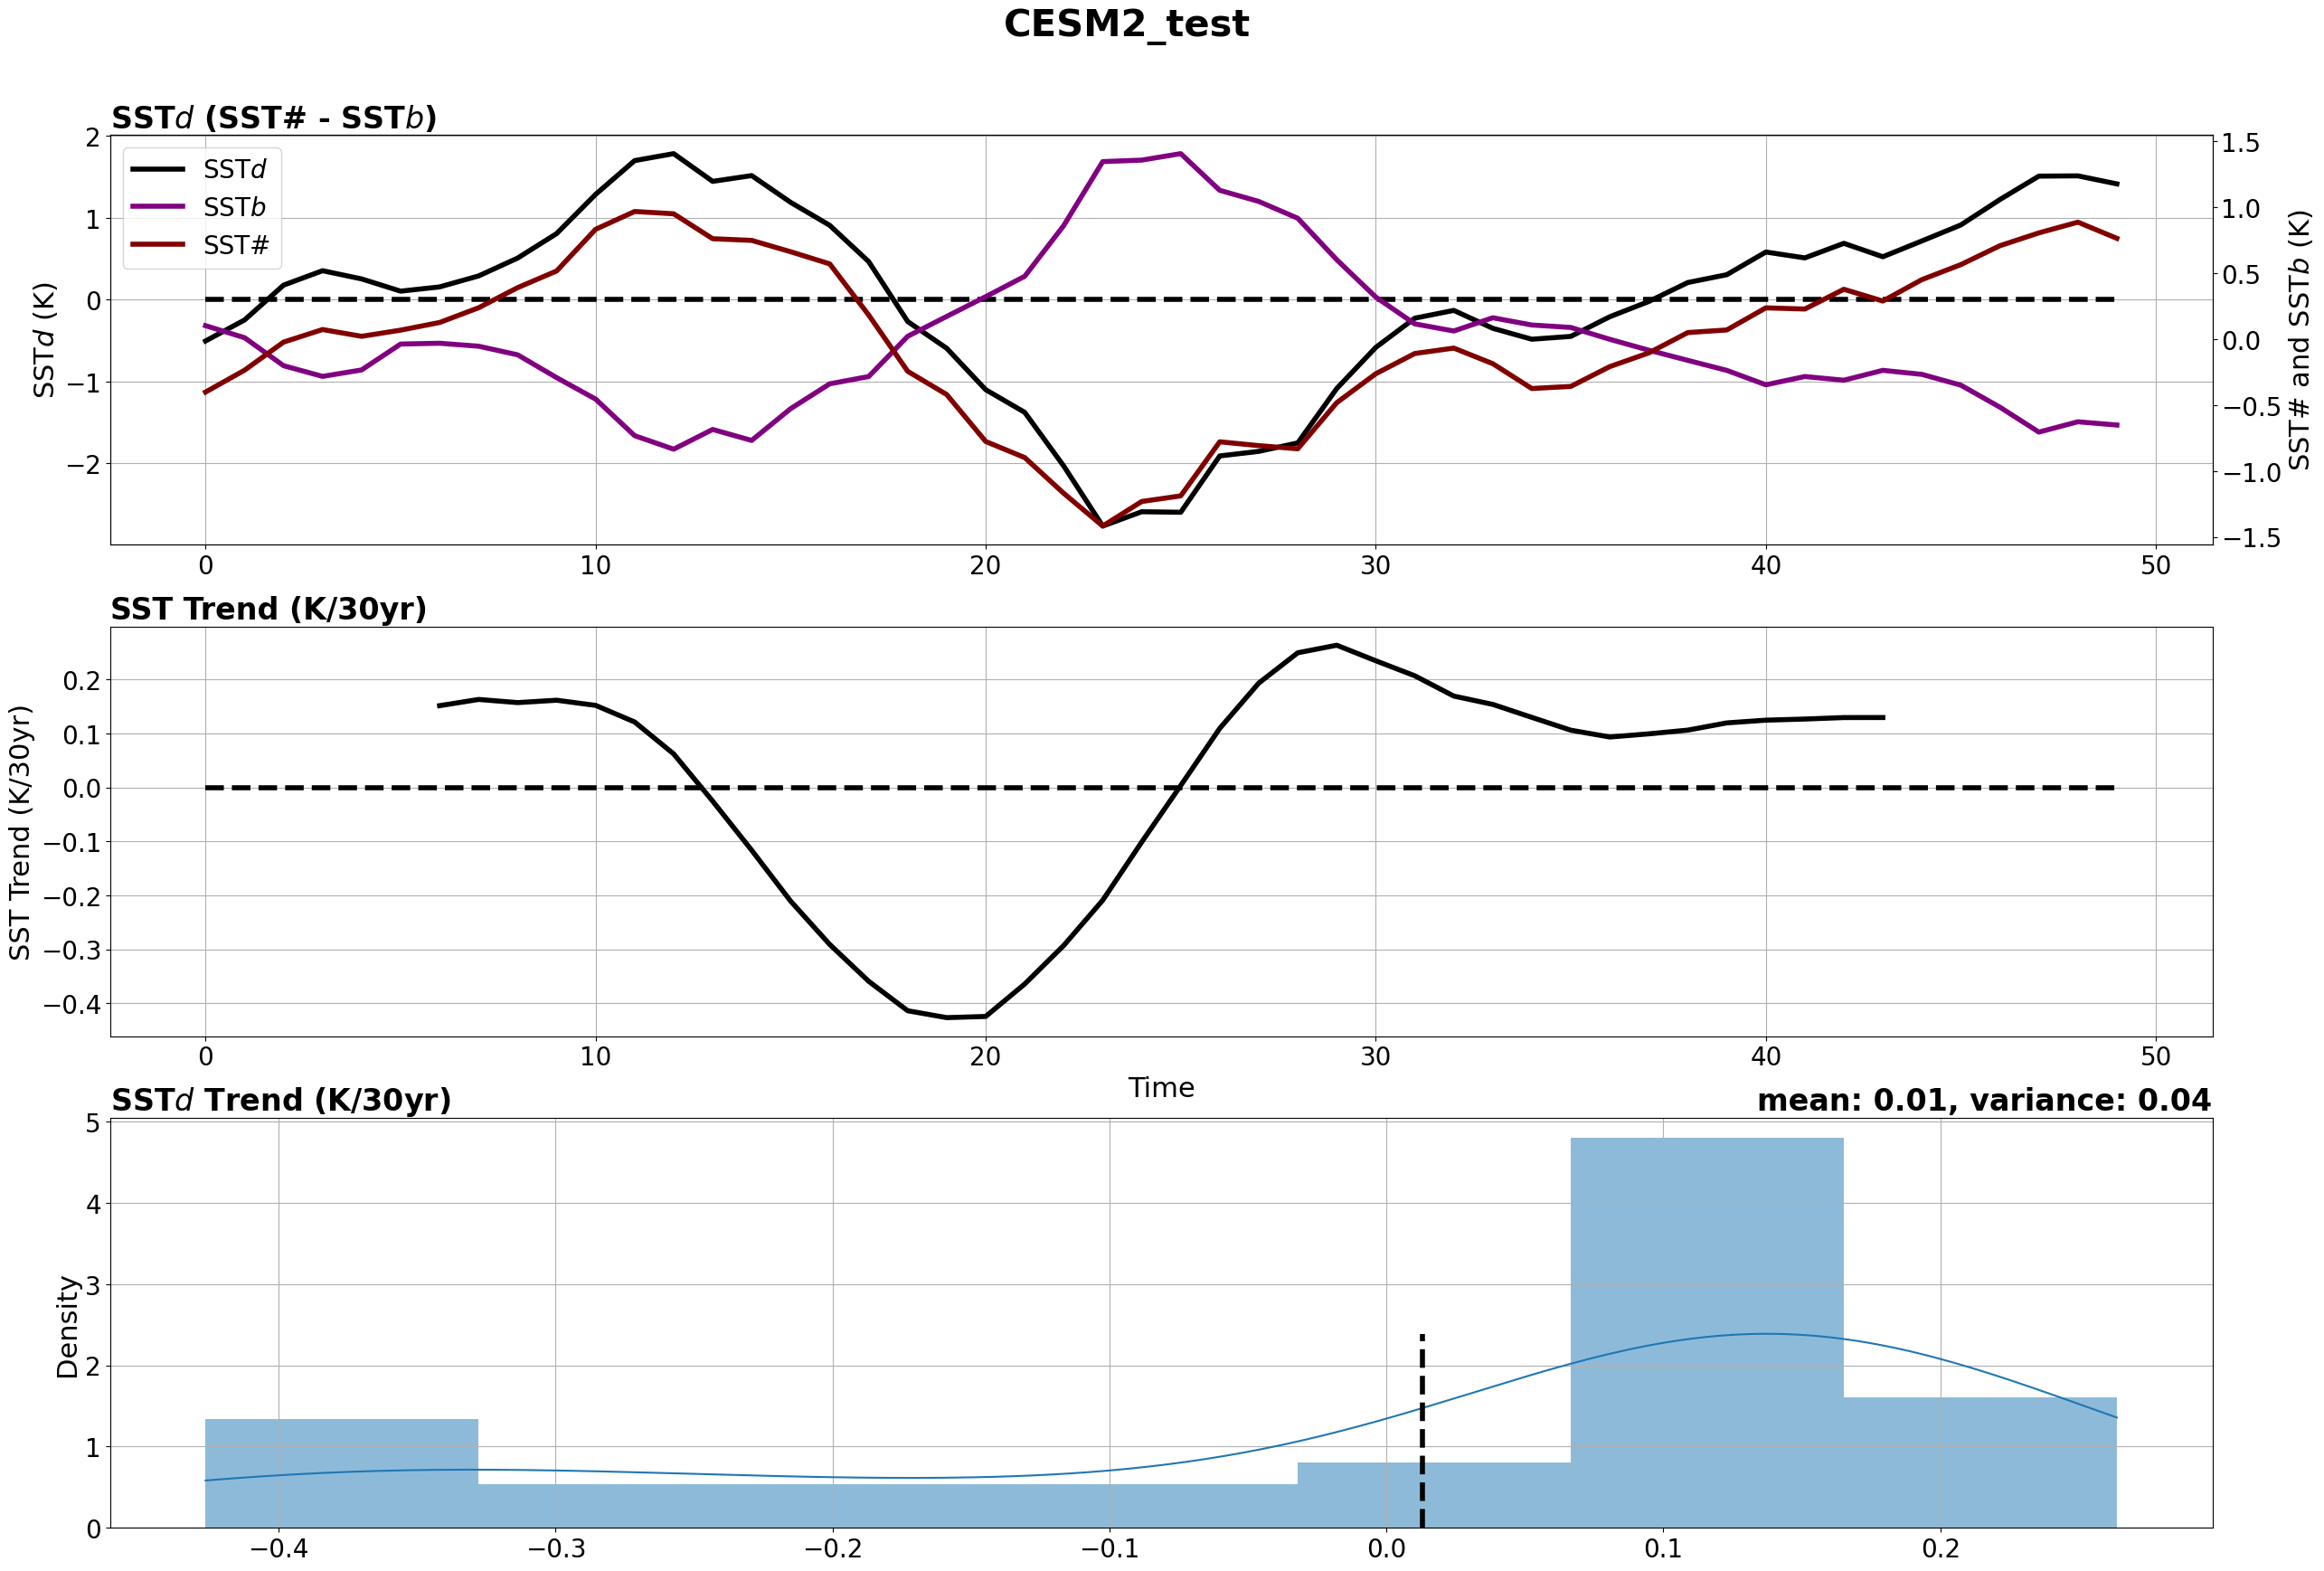

In [51]:
def sanity_rolling_trend(window: int, sharp: xr.DataArray, flat: xr.DataArray, trend: xr.DataArray, raw: xr.DataArray, model: str) -> None:
    # Create matplotlib 2 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(30, 20))
    ax1_twin = ax1.twinx()
    ntime = sharp.shape[0]
    time = np.arange(ntime)

    # Add grid lines to all subplots
    ax1.grid(); ax2.grid(); ax3.grid()

    # Plot time vs trend on ax1
    ax1.plot(time, raw, color='black', label=r"SST$d$", linewidth=4)

    # Plot sharp on ax1_twin
    ax1_twin.plot(time, flat, color='purple', label=r"SST$b$", linewidth=4)
    ax1_twin.plot(time, sharp, color='maroon', label=r"SST#", linewidth=4)
    ax1.set_ylabel(r"SST$d$ (K)"); ax1_twin.set_ylabel(r"SST# and SST$b$ (K)")
    ax1.set_title(r"SST$d$ (SST# - SST$b$)", loc="left", fontweight="bold")
    # Add a black horizontal line at 0 
    ax1.hlines(0, xmin=time[0], xmax=time[-1], color="black", linestyle="--", linewidth=4)
    # Retrieve the handles and labels from both axes
    handles1, labels1 = ax1.get_legend_handles_labels()
    handles2, labels2 = ax1_twin.get_legend_handles_labels()
    # Concatenate the handles and labels from both axes
    handles = handles1 + handles2
    labels = labels1 + labels2
    # Create the legend using the concatenated handles and labels
    ax1.legend(handles, labels)

    # Plot ntime vs raw on ax2
    ax2.plot(np.arange(int(window/2), ntime - int(window/2)), trend, color='black', label="trend", linewidth=4)
    # Set x lim to be the same as ax1
    ax2.set_xlim(ax1.get_xlim())
    ax2.set_title("SST Trend (K/30yr)", loc="left", fontweight="bold")
    ax2.set_ylabel("SST Trend (K/30yr)"); ax2.set_xlabel("Time")
    ax2.hlines(0, xmin=time[0], xmax=time[-1], color="black", linestyle="--", linewidth=4)

    hist = sns.histplot(trend, ax=ax3, kde=True, stat="density", linewidth=0)
    ax3.set_title(r"SST$d$ Trend (K/30yr)", loc="left", fontweight="bold")
    ax3.set_title(f"mean: {np.mean(trend):.2f}, variance: {np.var(trend):.2f}", loc="right", fontweight="bold")
    # Add a vertical line at the mean of the trend and the variance and have the ymin and ymax be the max of the histogram
    ax3.vlines(np.mean(trend), ymin=0, ymax=np.max(hist.get_lines()[0].get_data()[1]), color="black", linestyle="--", linewidth=4)
    fig.suptitle(model, fontsize=30, fontweight="bold", y=0.95)

    # Save figure to folder figures as pdf
    plt.savefig(f"figures/{model}_trend.pdf", bbox_inches='tight')
    plt.savefig(f"figures/{model}_trend.png", bbox_inches='tight')


def calculate_rolling_trend(data: xr.Dataset, model: str = "", window: int = 12*30, step: int = 12) -> xr.Dataset:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.Dataset): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """

    # Calculate SSTd = SSTsharp (warm) - SSTflat (cold)
    SSTd = data["sharp"] - data["flat"]
    ntime = SSTd.shape[0]

    SSTd_trend = np.zeros(int((ntime - window)/step))
    SSTd_trend.fill(np.nan)

    # Calculate rolling trend of SSTd
    time_idx = xr.DataArray(np.arange(window), dims=("time"))
    for j, i in enumerate(range(0, ntime - window, step)):
        slice_SSTd = SSTd.isel(time=slice(i, int(i+window)))
        SSTd_trend[j] = xscore.linslope(time_idx, slice_SSTd, dim='time', skipna=True).values
        # print(SSTd_trend[j])
    
    # Convert SSTd trend and SSTd to xr.DataArray
    SSTd_trend = xr.DataArray(SSTd_trend, dims=("time"), coords={"time": np.arange(SSTd_trend.shape[0])})
    # Convert SSTd to xr.DataArray
    SSTd = xr.DataArray(SSTd, dims=("time"), coords={"time": np.arange(SSTd.shape[0])})
    # Combine SSTd and SSTd_trend into xr.Dataset
    ds = xr.Dataset({"SSTd": SSTd, "SSTd_trend": SSTd_trend})
    # Sanity plot of SSTd and SSTd_trend
    sanity_rolling_trend(window=window, sharp=data["sharp"], flat=data["flat"], trend=SSTd_trend, raw=SSTd, model=model) 

    # Return SSTd and SSTd_trend
    return ds


calculate_rolling_trend(ds, model="CESM2_test", window=12, step=1)

In [70]:
def apply_SSTsharp_sorting(da: xr.DataArray, prctl_bins: np.ndarray, ds_sharp: xr.Dataset, model: str) -> xr.Dataset:
    """
    Apply SSTsharp sorting from ds_sharp to da xr.DataArray
    """
    pass

    """
    Returns:
        ds (xr.Dataset): containing the following xr.DataArrays:
            bingavg (xr.DataArray)[time, percentile]: average temperature in each percentile bin with quantile defined at that time step
            binanom (xr.DataArray)[time, percentile]: average temperature in each percentile bin minus the monthly climatology
            sortIdxs (xr.DataArray)[time, lon]: Indexes of the sorted data that can be used to sort other dataX (e.g. swcre, rsut, rsutcs) using dataY (e.g. SST)
            binanom_bar (xr.DataArray)[time, percentile]: binanoms minus the tropical average SST at that time step
            mean_anom (xr.DataArray)[time, percentile]: tropical average SST anomaly at that time step
            sharp (xr.DataArray)[time]: The average of binanom_bar over the warmest 30% at each time step
            flat (xr.DataArray)[time]:  The average of binanom_bar over the coldest 30% at each time step 

    """
    ntime, nlon = da.shape
    nbins = len(prctl_bins)
    

    binavg = np.zeros((ntime,nbins))
    binwts = np.zeros((ntime,nbins))

    for i in range(ntime):
        if i % 100 == 0:
            print("starting time step: ", i, " of ", ntime)

        # Get current time slice
        da_slice = da.isel(time=i)
        
        # Get weights (if we stick to the ocean, we don't need this)
        wts = np.ones(len(da_slice))

        # Get sorting Indexes
        inds = ds_sharp["sortIdxs"].isel(time=i).values

        for j, b in enumerate(np.arange(nbins)): # note that bin 0 only has a single (max) value
            numer = np.nansum(da_slice[np.where(inds==b)]*wts[np.where(inds==b)])
            denom = np.nansum(wts[np.where(inds==b)])
            binavg[i,j] = numer/denom
            binwts[i,j] = denom

    # Deseasonalize the data -- remove climatology computed over entire timeseries:
    binanom = np.zeros((ntime,nbins))
    for m in range(12):
        binanom[m::12,:] = binavg[m::12,:] - np.nanmean(binavg[m::12, :], 0)
    
    # Time slice SST mean
    TMean = np.nanmean(binanom, axis=1)[:, None]
    # Calculate binanom_bar
    binanom_bar = binanom - TMean
    # Calculate SSTsharp 
    sharpThreshold = np.where(prctl_bins==30)[0][0]+1    
    sharp = np.nansum(binanom_bar[:,:sharpThreshold]*binwts[:,:sharpThreshold],1) / np.nansum(binwts[:,:sharpThreshold],1)
    # Calculate SSTflat
    flatThreshold = np.where(prctl_bins==75)[0][0]    
    flat = np.nansum(binanom_bar[:,flatThreshold:]*binwts[:,flatThreshold:],1) / np.nansum(binwts[:,flatThreshold:],1)

    TMean = TMean.squeeze()

    # Create Dataset => remove first element that is nan for all bins
    ds = xr.Dataset({
        'binavg':(('time','bins'), binavg[:, 1:]),
        'binanom': (('time','bins'), binanom[:, 1:]), 
        'binanom_bar': (('time','bins'), binanom_bar[:, 1:]),
        'binwts':(('time','bins'), binwts[:, 1:]),
        'mean_anom':(('time'), TMean),
        'sharp':(('time'), sharp),
        'flat':(('time'), flat)
    },
        coords={
            'time': ds_sharp.time, 
            'bins': prctl_binmids,
            'lon': ds_sharp.lon 
        }
    ) 
    
    return ds


# Load cmip6 swcre data
swcre = xr.open_dataset("data/swcre_cmip6_monthly_1850-2000.nc")
swcre = swcre.bounds.add_bounds("X")
swcre = swcre.bounds.add_bounds("Y")
swcre = swcre.sel(lat=slice(-8, 8), lon=slice(110, 225)).spatial.average("swcre", axis="Y")["swcre"]

ds = apply_SSTsharp_sorting(
    da=swcre.sel(model="CESM2").isel(time=slice(0,50)), 
    ds_sharp=ds, 
    prctl_bins=prctl_bins,
    model="CESM2"
)



starting time step:  0  of  50


<xarray.Dataset>
Dimensions:      (time: 50, bins: 20, lon: 46)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1854-02-01
  * bins         (bins) float64 2.5 7.5 12.5 17.5 22.5 ... 82.5 87.5 92.5 97.5
  * lon          (lon) float64 111.2 113.8 116.2 118.8 ... 218.8 221.2 223.8
Data variables:
    binavg       (time, bins) float64 -26.68 -28.65 -25.85 ... -119.4 -113.6
    binanom      (time, bins) float64 21.74 25.66 24.96 ... -17.67 -25.8 -20.8
    binanom_bar  (time, bins) float64 10.33 14.25 13.55 ... -8.566 -3.565
    binwts       (time, bins) float64 3.0 2.0 2.0 2.0 3.0 ... 3.0 2.0 2.0 2.0
    mean_anom    (time) float64 11.41 13.06 0.07019 ... -8.337 -17.85 -17.23
    sharp        (time) float64 11.58 9.424 11.65 12.06 ... 1.882 3.296 -0.5157
    flat         (time) float64 -2.985 -4.71 -8.884 ... 13.91 8.55 -0.9929

In [64]:
ds

<xarray.Dataset>
Dimensions:      (time: 50, bins: 20, lon: 46)
Coordinates:
  * time         (time) datetime64[ns] 1850-01-01 1850-02-01 ... 1854-02-01
  * bins         (bins) float64 2.5 7.5 12.5 17.5 22.5 ... 82.5 87.5 92.5 97.5
  * lon          (lon) float64 111.2 113.8 116.2 118.8 ... 218.8 221.2 223.8
Data variables:
    binavg       (time, bins) float64 26.14 26.32 26.57 ... 30.0 30.01 30.02
    binanom      (time, bins) float64 -0.7315 -0.6973 ... 0.03779 -0.02578
    sortIdxs     (time, lon) float64 9.0 8.0 11.0 10.0 8.0 ... 3.0 2.0 2.0 1.0
    binanom_bar  (time, bins) float64 -0.6365 -0.6023 ... -0.7522 -0.8158
    binwts       (time, bins) float64 3.0 2.0 2.0 2.0 3.0 ... 3.0 2.0 2.0 2.0
    mean_anom    (time) float64 -0.09502 0.04047 0.3405 ... 0.7342 0.8348 0.79
    sharp        (time) float64 -0.4007 -0.235 -0.02185 ... 0.8065 0.8879 0.765
    flat         (time) float64 0.1026 0.01135 -0.2011 ... -0.6262 -0.6511

In [56]:
prctl_bins = np.arange(0,105,5) # bottom edge of percentile bins
prctl_binmids = (prctl_bins[:-1]+prctl_bins[1:])/2 # center of percentile bins

In [18]:
def calculate_SSTsharp(save: bool = False, testing: bool = False) -> xr.Dataset:
    """
    1. Load SST monthly raw data
    2. Iterate over each model, calculate SSTsharp package, create sanity check figures, and save to netcdf

    Args:
        save (bool, optional): Save the SSTsharp package for each model. Defaults to False.
        testing (bool, optional): If testing, only do first model and 50 time steps. Defaults to False.

    Returns:
        xr.Dataset: Dataset containing SSTsharp package for each model
    """

    tos = xr.open_dataset(f"data/tos_mon_1850-2100_CMIP6_piControl.nc", chunks="auto")
    tos = tos.bounds.add_bounds("X")
    tos = tos.bounds.add_bounds("Y")
    tos = tos.sel(lat=slice(-8, 8), lon=slice(110, 225)).spatial.average("tos", axis="Y")["tos"]
    
    models = tos.model.values
    ds = {}
    for i, model in enumerate(models):
        model = "CESM2"
        if not save: 
            print(f"Loading SST sharpness for {model}")
            ds[model] = xr.open_dataset(f"data/SSTsharp_{model}.nc")
            continue

        print(f"Calculating SST sharpness for {model}")
        # Testing
        ctos = tos.sel(model=model)
        if testing:
            ctos = tos.sel(model=model).isel(time=slice(0,50))

        ds_model = do_SSTsharp_sorting(ctos, prctl_bins=prctl_bins, prctl_binmids=prctl_binmids)
        # ds_model = do_rolling_mean(ds_model, window=12)
        if save:
            ds_model.to_netcdf(f"data/SSTsharp_{model}.nc")

        ds[model] = ds_model

        if testing: 
            create_percentile_figures(ds_model, model=model)
            return ds

    return ds

ds = calculate_SSTsharp(save=True, testing=True)


Calculating SST sharpness for CESM2
starting time step:  0  of  50
